In [1]:
import cv2 as cv
import numpy as np
import nibabel as nib
from tqdm import tqdm
from itertools import product
from perlin_numpy import generate_perlin_noise_3d

import matplotlib.pyplot as plt

import neurite as ne
import tensorflow as tf
import voxelmorph as vxm

from lsm.synthetic.synthseg_utils import (
    draw_value_from_distribution,
    SampleConditionalGMM)


2024-06-05 14:44:29.224367: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 14:44:29.285004: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 14:44:29.285041: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 14:44:29.285068: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-05 14:44:29.295904: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 14:44:29.297279: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# load a test label stack
orig_labels = nib.load(f'/om2/user/ckapoor/generative_model_steerable_gaussians/outputs/initial_labels/stack_0000.nii.gz').get_fdata()

In [3]:
# choose randmode for padding
randmode = np.random.choice(['constant', 'reflect'])
randpad_x = np.random.choice([0, 32, 64, 96])
randpad_y = np.random.choice([0, 32, 64, 96])
randpad_z = np.random.choice([0, 32, 64, 96])

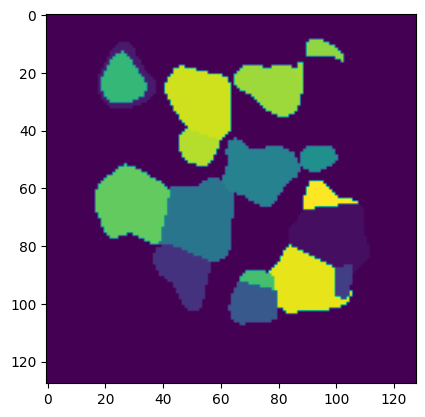

In [4]:
plt.imshow(orig_labels[64,...])

In [5]:
# pad label image
padded_labels = np.pad(
                orig_labels,
                [
                    [randpad_x, randpad_x],
                    [randpad_y, randpad_y],
                    [randpad_z, randpad_z],
                ],
                mode=randmode,
)

In [6]:
# resize labels
from skimage.transform import resize
current_labels = resize(
                padded_labels,
                (128, 128, 128),
                preserve_range=True,
                anti_aliasing=False,
                order=0,)

In [7]:
from skimage.measure import label as unique_label

current_labels = unique_label(current_labels).astype(np.uint16)

# begin GMM procedure
means = draw_value_from_distribution(
                None,
                len(np.unique(current_labels)),
                "uniform",
                125,
                100,
                positive_only=True,
            )
stds = draw_value_from_distribution(
                None,
                len(np.unique(current_labels)),
                "uniform",
                15,
                10,
                positive_only=True,
            )

In [31]:
backgnd_mode = np.random.choice(["plain", "rand", "perlin"])
print(f'bg mode: {backgnd_mode}')

bg mode: perlin


In [32]:
if backgnd_mode == "plain":                                 
    min_mean = means.min() * np.random.rand(1)              
    means[0] = 1.0 * min_mean                               
    stds[0] = np.random.uniform(0.0, 5.0, 1)                
elif backgnd_mode == "perlin":                              
    # Inspired by the sm-shapes generative model from       
    # https://martinos.org/malte/synthmorph/                
    n_texture_labels = np.random.randint(1, 21)             
    idx_texture_labels = np.arange(0, n_texture_labels, 1)  
    im = ne.utils.augment.draw_perlin(                      
        out_shape=(128, 128, 128, n_texture_labels),        
        scales=(32, 64),                                    
        max_std=1,                                          
    )                                                       
    try:                                                    
        warp = ne.utils.augment.draw_perlin(                
            out_shape=(128, 128, 128, n_texture_labels, 3), 
            scales=(16, 32, 64),                            
            max_std=16,                                     
        )                                                   
    except:                                                 
        pass
                                                            
    # Transform and create background label map.            
    im = vxm.utils.transform(im, warp)                      
    background_struct = np.uint8(tf.argmax(im, axis=-1))    
                                                            
    # Background moments for GMM:                           
    background_means = draw_value_from_distribution(        
        None,                                               
        len(np.unique(idx_texture_labels)),                 
        "uniform",                                          
        125,                                                
        100,                                                
        positive_only=True,                                 
    )                                                       
    background_stds = draw_value_from_distribution(         
        None,                                               
        len(np.unique(idx_texture_labels)),                 
        "uniform",                                          
        15,                                                 
        10,                                                 
        positive_only=True,                                 
    )                                                       

In [33]:
# Sample perlin noise for cell texture here                               
randperl = ne.utils.augment.draw_perlin(                                  
    out_shape=(128, 128, 128, 1),                                         
    scales=(2, 4, 8, 16, 32),                                             
    max_std=5.0,                                                          
)[..., 0].numpy()                                                         
randperl = (randperl - randperl.min()) / (randperl.max() - randperl.min())

In [34]:
# Create foreground:                                        
synthlayer = SampleConditionalGMM(np.unique(current_labels))
synthimage = synthlayer(                                    
    [                                                       
        tf.convert_to_tensor(                               
            current_labels[np.newaxis, ..., np.newaxis],    
            dtype=tf.float32,                               
        ),                                                  
        tf.convert_to_tensor(                               
            means[tf.newaxis, ..., tf.newaxis],             
            dtype=tf.float32,                               
        ),                                                  
        tf.convert_to_tensor(                               
            stds[tf.newaxis, ..., tf.newaxis],              
            dtype=tf.float32,                               
        ),                                                  
    ]                                                       
)[0, ..., 0].numpy()                                        

In [35]:
# Use multiplicative Perlin noise on foreground:                 
synthimage[current_labels > 0] = (                               
    synthimage[current_labels > 0] * randperl[current_labels > 0]
)                                                                
del synthlayer                                                   

In [36]:
if backgnd_mode == "plain" or backgnd_mode == "rand":          
    synthimage[current_labels == 0] = synthimage[              
        current_labels == 0                                    
    ] * np.mean(randperl[current_labels == 0])                 
elif backgnd_mode == "perlin":                                 
    synthlayer = SampleConditionalGMM(idx_texture_labels)      
    synthbackground = synthlayer(                              
        [                                                      
            tf.convert_to_tensor(                              
                background_struct[np.newaxis, ..., np.newaxis],
                dtype=tf.float32,                              
            ),                                                 
            tf.convert_to_tensor(                              
                background_means[tf.newaxis, ..., tf.newaxis], 
                dtype=tf.float32,                              
            ),                                                 
            tf.convert_to_tensor(                              
                background_stds[tf.newaxis, ..., tf.newaxis],  
                dtype=tf.float32,                              
            ),                                                 
        ]                                                      
    )[0, ..., 0].numpy() 
    # corrupt background with perlin noise
    synthimage[current_labels == 0] = synthbackground[         
        current_labels == 0                                    
    ] * np.mean(randperl[current_labels == 0])                 
    del synthlayer                                             

In [37]:
synthbackground[current_labels==0].shape

(2044797,)

# augment background with random kernels

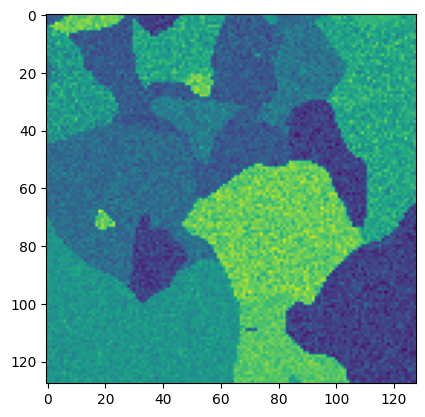

In [38]:
plt.imshow(synthbackground[64,...])

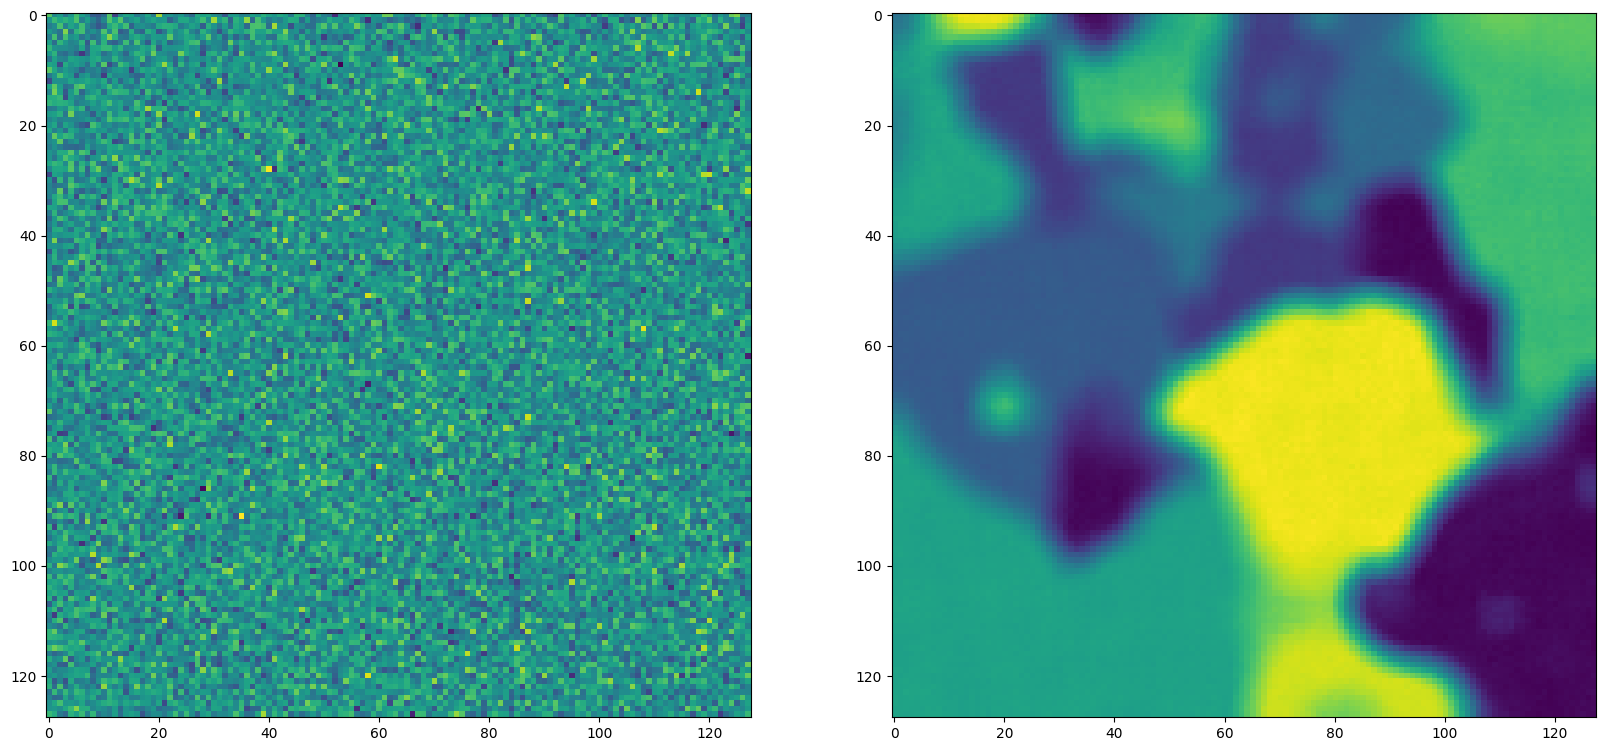

In [42]:
# random kernel + random conv
x = np.random.randn(128, 128, 128) # image slice
k = np.abs(np.random.randn(7, 7, 7)) # kernel

from scipy.ndimage import convolve

conv_pattern = convolve(x, k)
random_conv_perlin = convolve(orig_bg, k)
random_conv_perlin /= random_conv_perlin.max()

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(x[64,...])
plt.subplot(1, 2, 2)
plt.imshow(random_conv_perlin[64,...])
plt.show()
#plt.imshow(2, 1, 1)
#plt.imshow(conv_pattern[64,...])

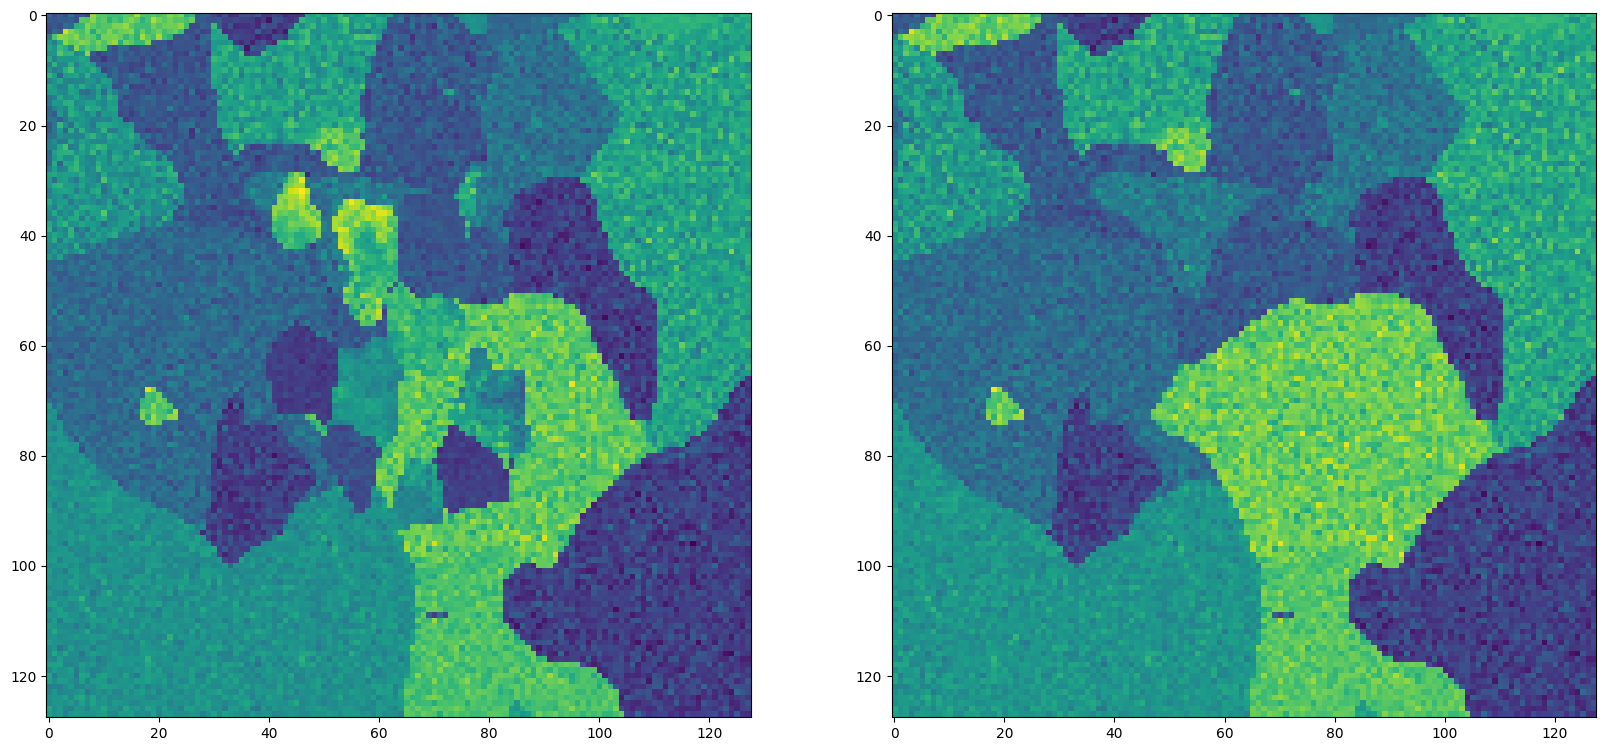

In [41]:
# original image + synthetic background

orig_img = synthimage
orig_bg = synthbackground

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(orig_img[64,...])
plt.subplot(1, 2, 2)
plt.imshow(orig_bg[64,...])

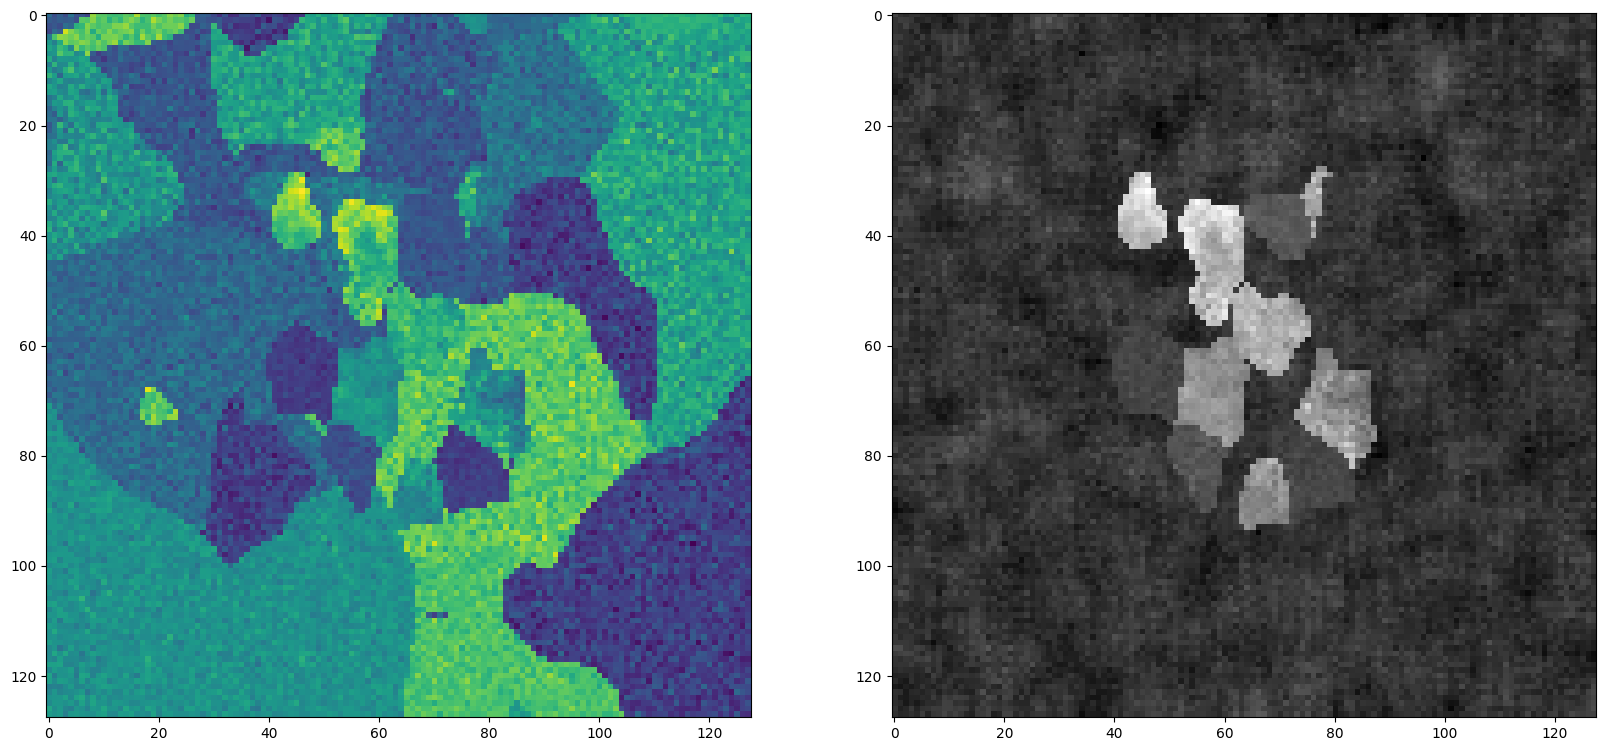

In [44]:
alpha = 0.5
#blended = cv.addWeighted(orig_img, alpha, conv_pattern.astype('float32'), 1-alpha, 0)
blended = orig_img.copy()
blended[current_labels == 0] = conv_pattern[current_labels == 0] * alpha # only corrupt background

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(orig_img[64,...])
plt.subplot(1, 2, 2)
plt.imshow(blended[64,...], cmap='gray')

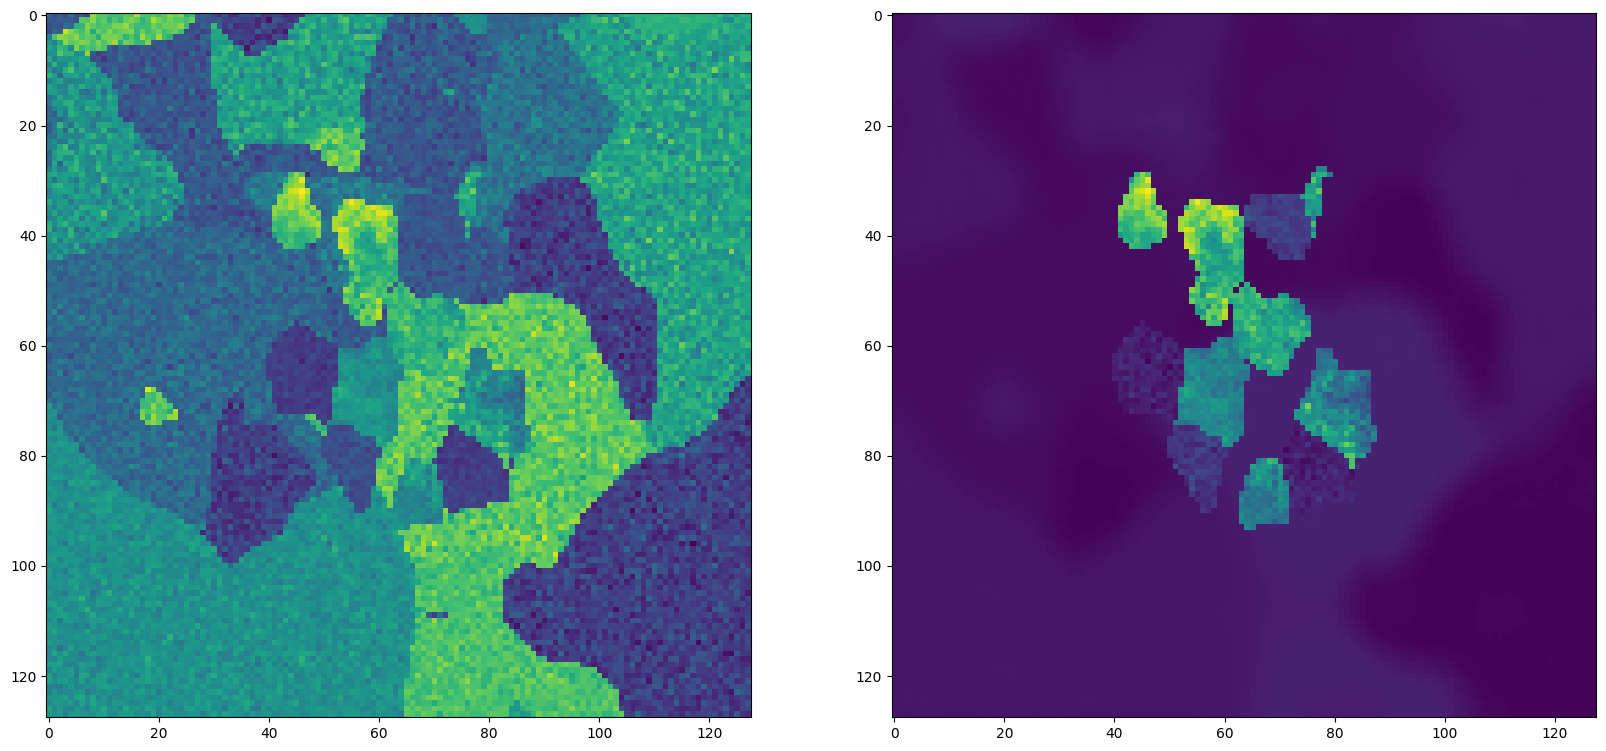

In [45]:
alpha = 15
#blended = cv.addWeighted(orig_img, alpha, random_conv_perlin.astype('float32'), 1-alpha, 0)
blended = orig_img.copy()
blended[current_labels == 0] = random_conv_perlin[current_labels == 0] * alpha  # only corrupt baclground pixels

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(orig_img[64,...])
plt.subplot(1, 2, 2)
plt.imshow(blended[64,...])

# steerable 3d gaussians (random noise)

In [46]:
from scipy.ndimage import gaussian_filter

def gaussian_3d_kernel(size, sigma):
    x, y, z = np.meshgrid(np.linspace(-1, 1, size[0]), 
                          np.linspace(-1, 1, size[1]), 
                          np.linspace(-1, 1, size[2]), indexing='ij')
    distance = np.sqrt(x**2 + y**2 + z**2)
    kernel = np.exp(-(distance**2 / (2.0 * sigma**2)))
    kernel = kernel / np.sum(kernel)
    return kernel

def gaussian_derivative_3d(image, sigma):
    # take 1st derivative along x, y, z
    gx = gaussian_filter(image, sigma=sigma, order=[1, 0, 0])
    gy = gaussian_filter(image, sigma=sigma, order=[0, 1, 0])
    gz = gaussian_filter(image, sigma=sigma, order=[0, 0, 1])
    return gx, gy, gz

def steerable_filter_3d(image, sigma, theta, phi):
    gx, gy, gz = gaussian_derivative_3d(image, sigma)
    
    # steerable filter response
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    
    # linear combination of basis vectors 
    filtered_image = (cos_theta * cos_phi * gx +
                      sin_theta * cos_phi * gy +
                      sin_phi * gz)
    
    return filtered_image

In [47]:
from scipy.ndimage import rotate

def gaussian_3d_kernel(size, sigma):
    #x, y, z = np.meshgrid(np.random.randn(0, 1, size[0]), 
    #                      np.random.randn(0, 1, size[1]), 
    #                      np.random.randn(0, 1, size[2]), indexing='ij')
    x = np.random.normal(0, 1, size[0])
    y = np.random.normal(0, 1, size[1])
    z = np.random.normal(0, 1, size[2])
    
    x, y, z = np.meshgrid(x, y, z, indexing='ij')
    
    distance = np.sqrt(x**2 + y**2 + z**2)
    kernel = np.exp(-(distance**2 / (2.0 * sigma**2)))
    kernel = kernel / np.sum(kernel)
    return kernel

def rotate_3d_kernel(kernel, angles):
    rotated_kernel = rotate(kernel, angle=angles[0], axes=(1, 2), reshape=False)
    rotated_kernel = rotate(rotated_kernel, angle=angles[1], axes=(0, 2), reshape=False)
    rotated_kernel = rotate(rotated_kernel, angle=angles[2], axes=(0, 1), reshape=False)
    return rotated_kernel



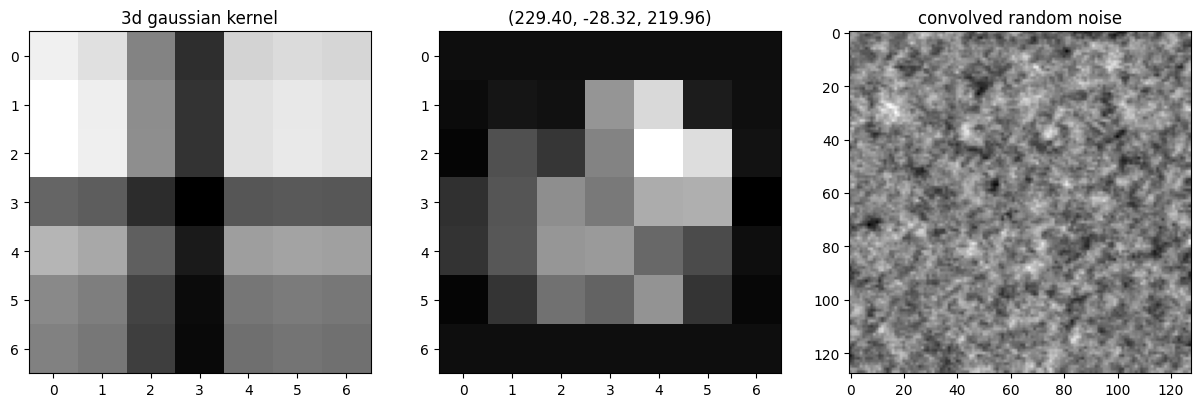

In [50]:
test_kernel = gaussian_3d_kernel(size=(7, 7, 7), sigma=1.)
theta = np.random.uniform(0, 360)
psi = np.random.uniform(0, 360)
phi = np.random.uniform(-90, 90)
rotate_kernel = rotate_3d_kernel(kernel=test_kernel, angles=(theta, phi, psi))
steerable_random_conv = convolve(x, rotate_kernel)

_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(test_kernel[1,...], cmap='gray')
ax[0].set_title("3d gaussian kernel")
ax[1].imshow(rotate_kernel[1,...], cmap='gray')
ax[1].set_title(f"({theta:.2f}, {phi:.2f}, {psi:.2f})")
ax[2].imshow(steerable_random_conv[64,...], cmap='gray')
ax[2].set_title("convolved random noise")
plt.show()

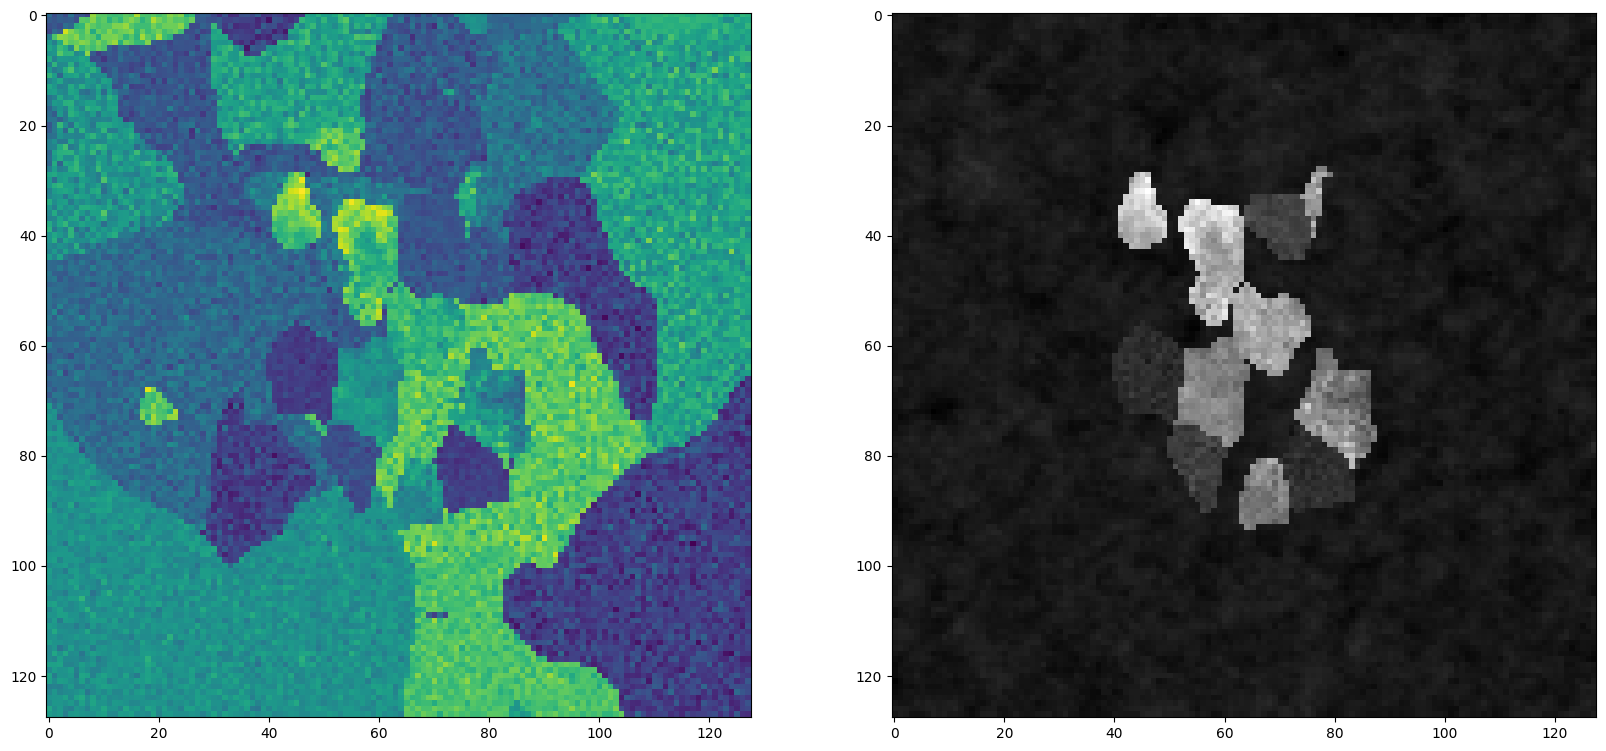

In [52]:
alpha = 100
#blended = cv.addWeighted(orig_img, alpha, steerable_random_conv.astype('float32'), 1-alpha, 0)
blended = orig_img.copy()
blended[current_labels == 0] = steerable_random_conv[current_labels == 0] * alpha  # only corrupt baclground pixels

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(orig_img[64,...])
plt.subplot(1, 2, 2)
plt.imshow(blended[64,...], cmap='gray')

# steerable 3d gaussians (perlin noise)

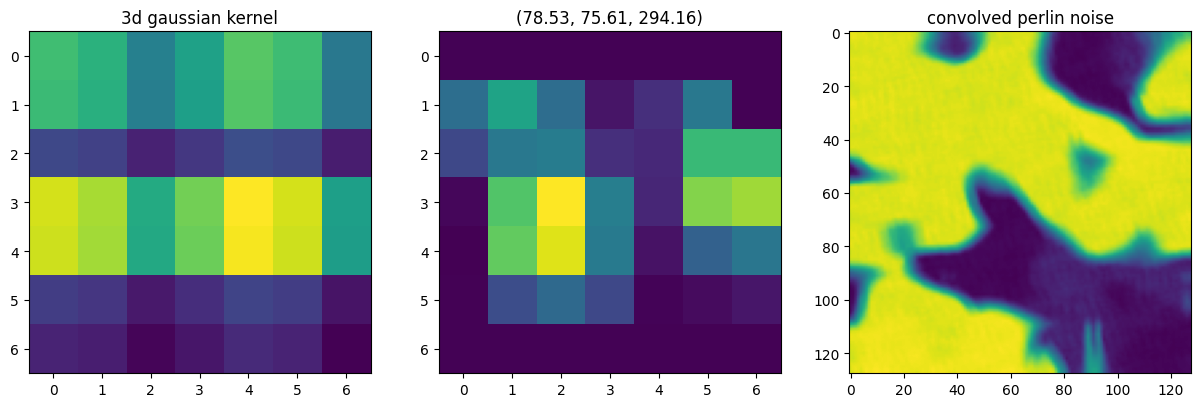

In [228]:
steerable_perlin_conv = convolve(orig_bg, rotate_kernel)

_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(test_kernel[1,...])
ax[0].set_title("3d gaussian kernel")
ax[1].imshow(rotate_kernel[1,...])
ax[1].set_title(f"({theta:.2f}, {phi:.2f}, {psi:.2f})")
ax[2].imshow(steerable_perlin_conv[64,...])
ax[2].set_title("convolved perlin noise")
plt.show()

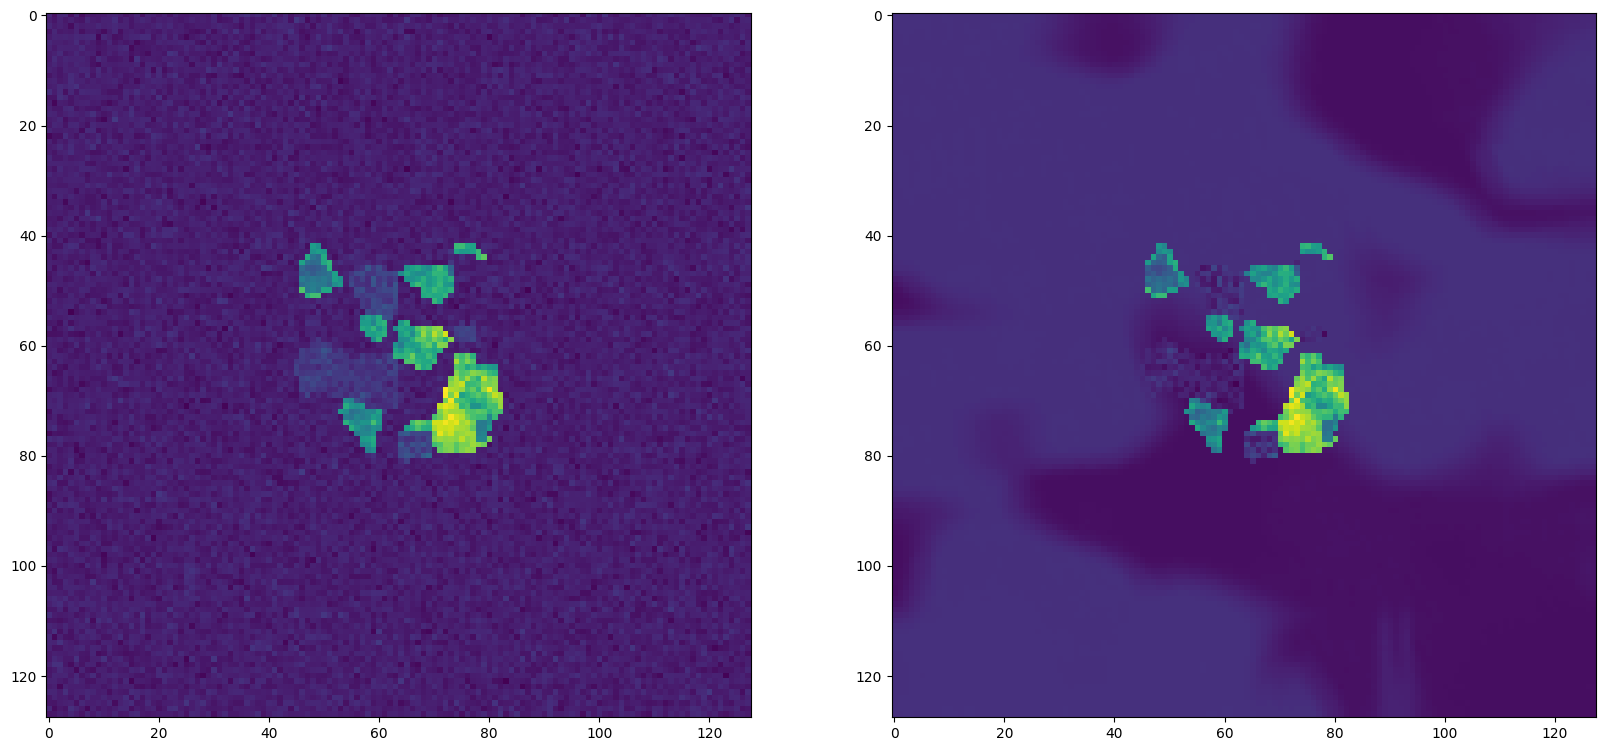

In [246]:
alpha = 0.2
#blended = cv.addWeighted(orig_img, alpha, steerable_perlin_conv.astype('float32'), 1-alpha, 0)
blended = orig_img.copy()
blended[current_labels == 0] = steerable_perlin_conv[current_labels == 0] * alpha  # only corrupt background pixels

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(orig_img[64,...])
plt.subplot(1, 2, 2)
plt.imshow(blended[64,...])

# steerable 3d spherical harmonics

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm
from mpl_toolkits.mplot3d import Axes3D

def viz_harmonics(l, resolution=100):
    total = (2*l)+1
    ncols = int(np.ceil(((2*l)+1)**0.5))
    nrows = int(np.ceil(((2*l)+1) / ncols))
    _, axes = plt.subplots(ncols, nrows, subplot_kw={'projection': '3d'}, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()
    theta = np.linspace(0, np.pi, resolution)
    phi = np.linspace(0, 2 * np.pi, resolution)
    theta, phi = np.meshgrid(theta, phi)

    spher = []

    for m in range(-l, l+1):
        Y_lm = sph_harm(m, l, phi, theta).real
        r = np.abs(Y_lm)
        
        x = r * np.sin(theta) * np.cos(phi)
        y = r * np.sin(theta) * np.sin(phi)
        z = r * np.cos(theta)

        fmax, fmin = Y_lm.max(), Y_lm.min()
        Y_lm = (Y_lm - fmin)/(fmax - fmin + eps)

        spher.append(Y_lm)

    for ax_i, ax in enumerate(axes):
        if ax_i < total:
            x = r * np.sin(theta) * np.cos(phi)
            y = r * np.sin(theta) * np.sin(phi)
            z = r * np.cos(theta)
            ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.seismic(spher[ax_i]), antialiased=True)
            ax.set_title(f'$Y_{{{l}}}^{{{ax_i-l}}}$')
            ax.set_axis_off()
        else:
            ax.axis('off')
            

    plt.tight_layout()
    plt.show()

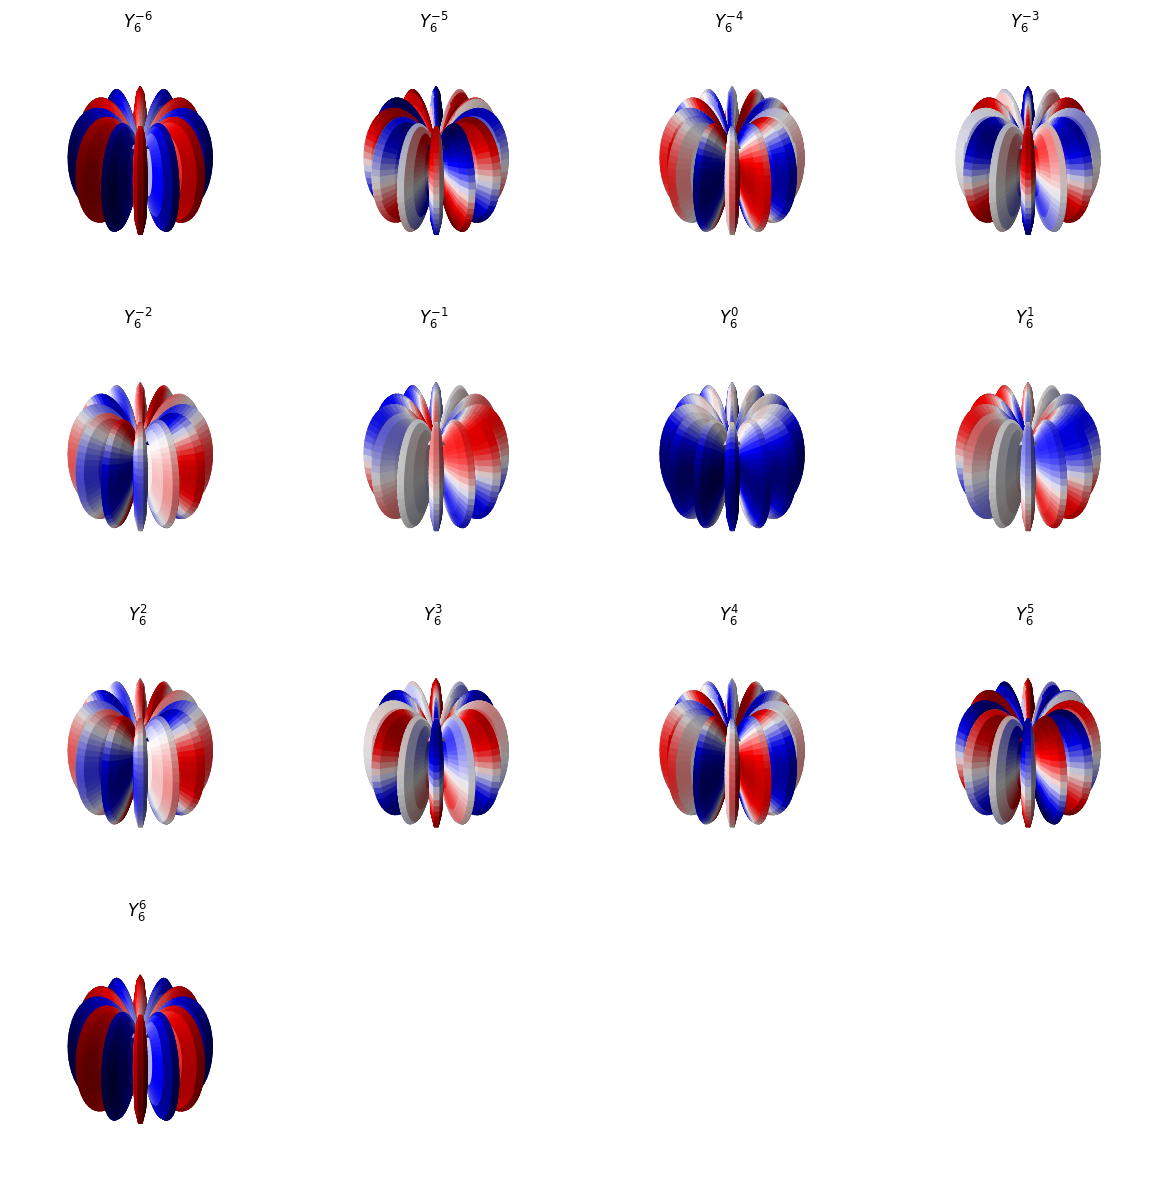

In [361]:
viz_harmonics(l=6)

In [55]:
def compute_spherical_harmonics(l, m, phi, theta):
    # compute harmonics of degree l, order m at (theta, phi)
    return sph_harm(m, l, phi, theta)

def spherical_to_cartesian(r, theta, phi):
    # convert spherical to cartesian coordinates
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    
    return x, y, z

def create_grid(size):
    # create a grid of 3d spherical coordinates
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy, zz = np.meshgrid(ax, ax, ax, indexing='ij')
    r = np.sqrt(xx**2 + yy**2 + zz**2)
    theta = np.arccos(np.clip(zz / r, -1, 1)) # ensure numerical stability
    # !!!!!
    # change based on - https://en.wikipedia.org/wiki/Spherical_coordinate_system#Cartesian_coordinates
    phi = np.arctan2(yy, xx)     
    return r, theta, phi

def gaussian_3d_kernel(size, sigma):
    x = np.random.normal(0, 1, size[0])
    y = np.random.normal(0, 1, size[1])
    z = np.random.normal(0, 1, size[2])
    
    x, y, z = np.meshgrid(x, y, z, indexing='ij')
    
    distance = np.sqrt(x**2 + y**2 + z**2)
    kernel = np.exp(-(distance**2 / (2.0 * sigma**2)))
    kernel = kernel / np.sum(kernel)
    return kernel, (x, y, z)

def project_spherical_harmonic(size, sigma, l, m, angles):
    # compute a (random) 3d gaussian kernel
    gaussian, (x, y, z) = gaussian_3d_kernel(size=size, sigma=sigma)

    # steer the gaussian
    gaussian = rotate_3d_kernel(kernel=gaussian, angles=angles)
    
    # cartesian to spherical coordinates
    r = np.sqrt(x**2 + y**2 + z**2)
    # ensure range of arccos is [-1, 1]
    theta = np.arccos(np.clip(z/r, -1, 1))
    phi = np.sign(y) * np.arccos(np.clip(x/np.sqrt(x**2 + y**2), -1, 1))
    
    harmonic_basis = compute_spherical_harmonics(l=l, m=m, phi=phi, theta=theta).real
    
    projected_gaussian = harmonic_basis * gaussian # project gaussians to a spherical harmonic basis

    return projected_gaussian

In [57]:
theta = np.random.uniform(0, 360)
psi = np.random.uniform(0, 360)
phi = np.random.uniform(-90, 90)
spherical_basis_gaussian = project_spherical_harmonic(size=(7, 7, 7), sigma=1., l=2, m=2, angles=(theta, psi, phi))

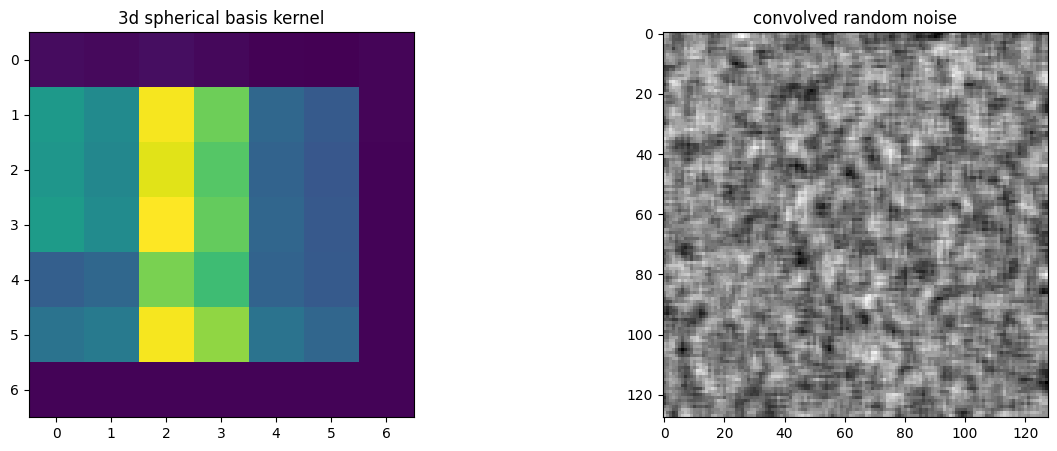

In [58]:
steerable_spherical_random_conv = convolve(x, spherical_basis_gaussian)

_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(spherical_basis_gaussian[1,...])
ax[0].set_title("3d spherical basis kernel")
ax[1].imshow(steerable_spherical_random_conv[64,...], cmap='gray')
ax[1].set_title("convolved random noise")
plt.show()

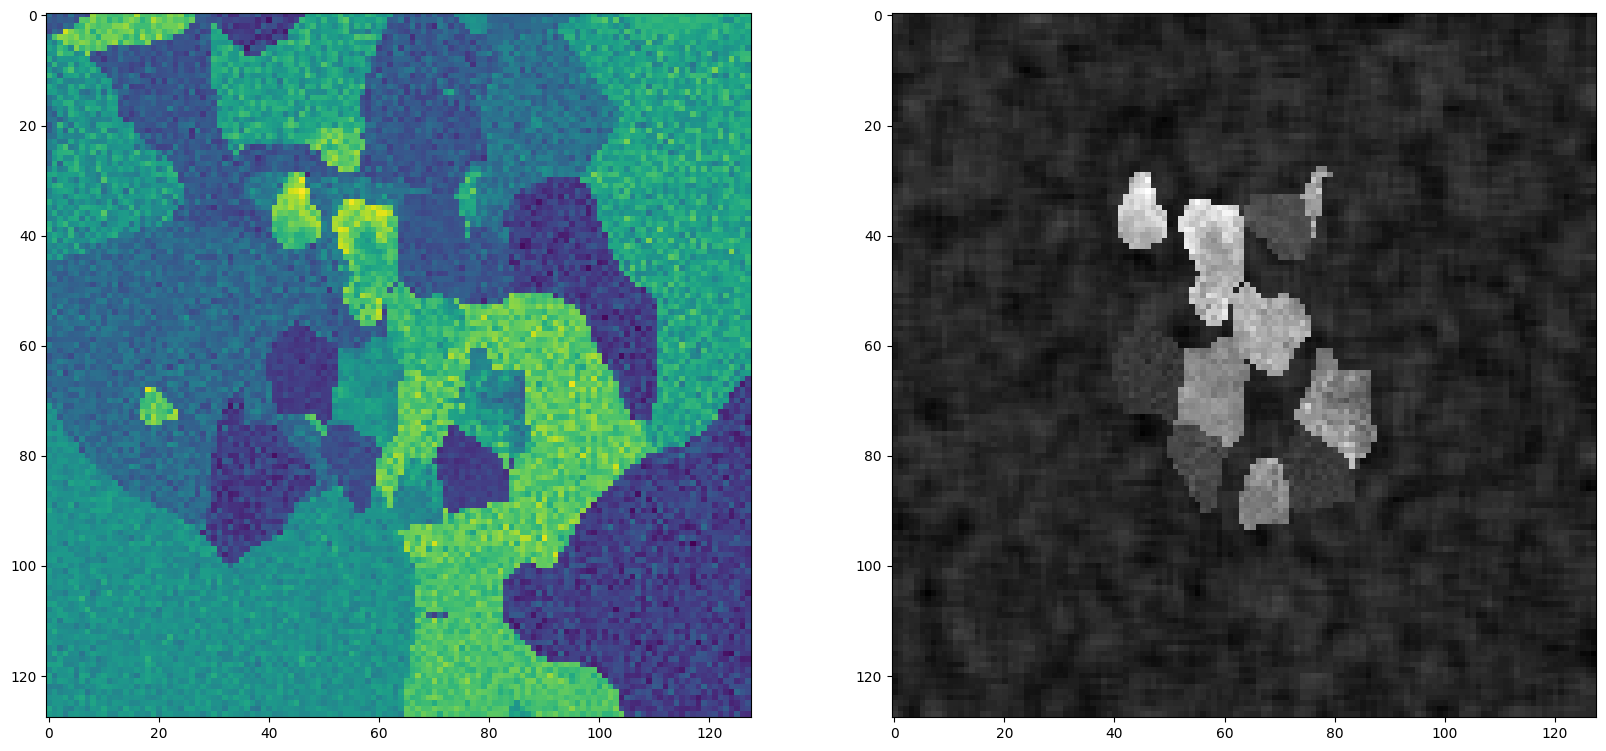

In [59]:
alpha = 500
#blended = cv.addWeighted(orig_img, alpha, steerable_spherical_random_conv.astype('float32'), 1-alpha, 0)
blended = orig_img.copy()
blended[current_labels == 0] = steerable_spherical_random_conv[current_labels == 0] * alpha  # only corrupt background pixels

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(orig_img[64,...])
plt.subplot(1, 2, 2)
plt.imshow(blended[64,...], cmap='gray')

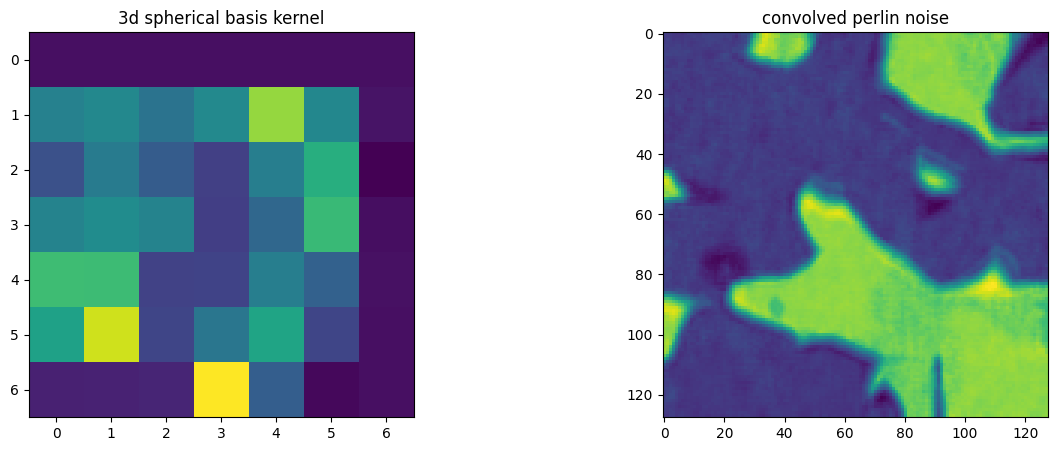

In [402]:
steerable_spherical_perlin_conv = convolve(orig_bg, spherical_basis_gaussian)

_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(spherical_basis_gaussian[1,...])
ax[0].set_title("3d spherical basis kernel")
ax[1].imshow(steerable_spherical_perlin_conv[64,...])
ax[1].set_title("convolved perlin noise")
plt.show()

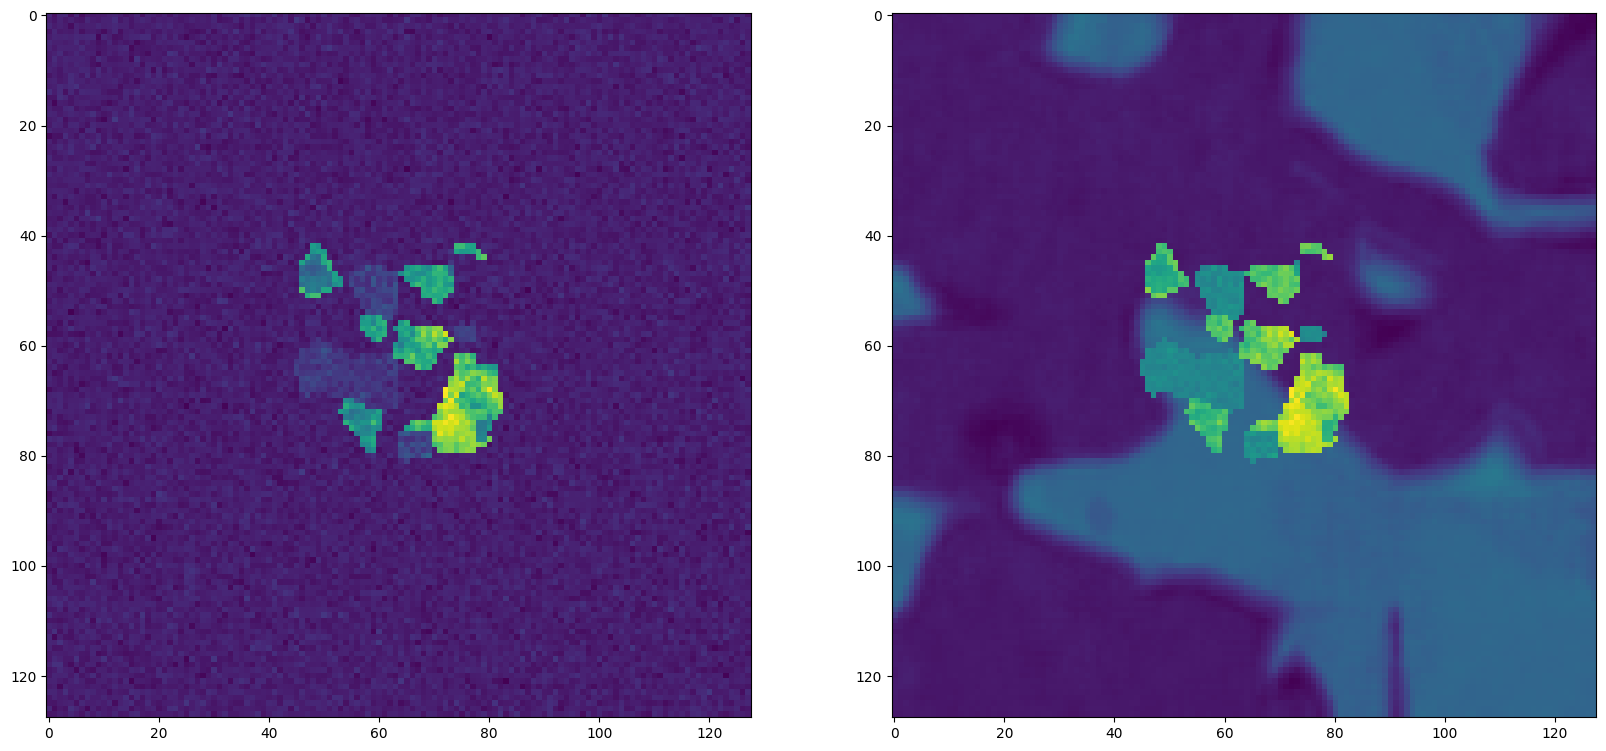

In [414]:
alpha = 12
#blended = cv.addWeighted(orig_img, alpha, steerable_spherical_perlin_conv.astype('float32'), 1-alpha, 0)
blended = orig_img.copy()
blended[current_labels == 0] = steerable_spherical_perlin_conv[current_labels == 0] * alpha  # only corrupt background pixels

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(orig_img[64,...])
plt.subplot(1, 2, 2)
plt.imshow(blended[64,...])

# check synthetic images

In [60]:
im = nib.load(f'/om2/user/ckapoor/generative_model_steerable_gaussians/outputs/training_images/stack_0003/stack_0003_0000_v13.nii.gz').get_fdata()
label = nib.load(f'/om2/user/ckapoor/generative_model_steerable_gaussians/outputs/training_labels/stack_0003/stack_0003_0000_v13.nii.gz').get_fdata()

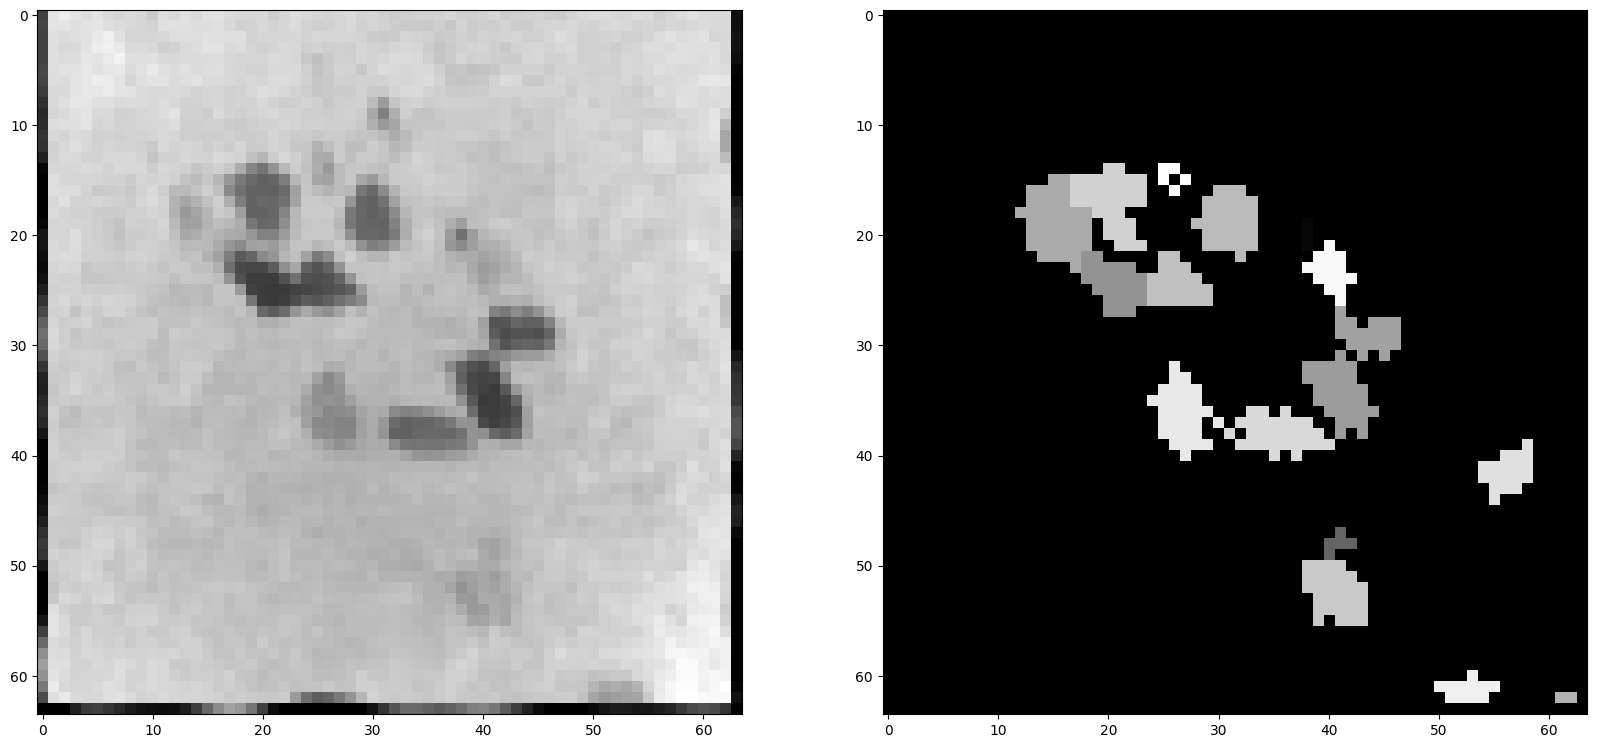

In [61]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(im[20,...], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(label[20,...], cmap='gray')

((64, 64, 64), (64, 64, 64))